In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

import numpy as np
import matplotlib.pyplot as plt
import os
import random

tf.config.list_physical_devices()

2022-08-11 18:15:35.747798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:15:35.813557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:15:35.814453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2022-08-11 18:15:37.439657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 18:15:37.442701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:15:37.442920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 18:15:37.443071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

**Resuidual Connection**

*Residual bocks where no of filters changes*

In [10]:
inputs = keras.Input(shape=(32,32,3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)

x = layers.add([x, residual])

*Residual bocks where the target block includes a max pooling layer*

In [11]:
inputs = keras.Input(shape=(32,32,3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)

# adding strides=2 to balance with max pooling layer
residual = layers.Conv2D(64, 1, strides=2)(residual)

x = layers.add([x, residual])

*Convnets with Residual blocks in action*

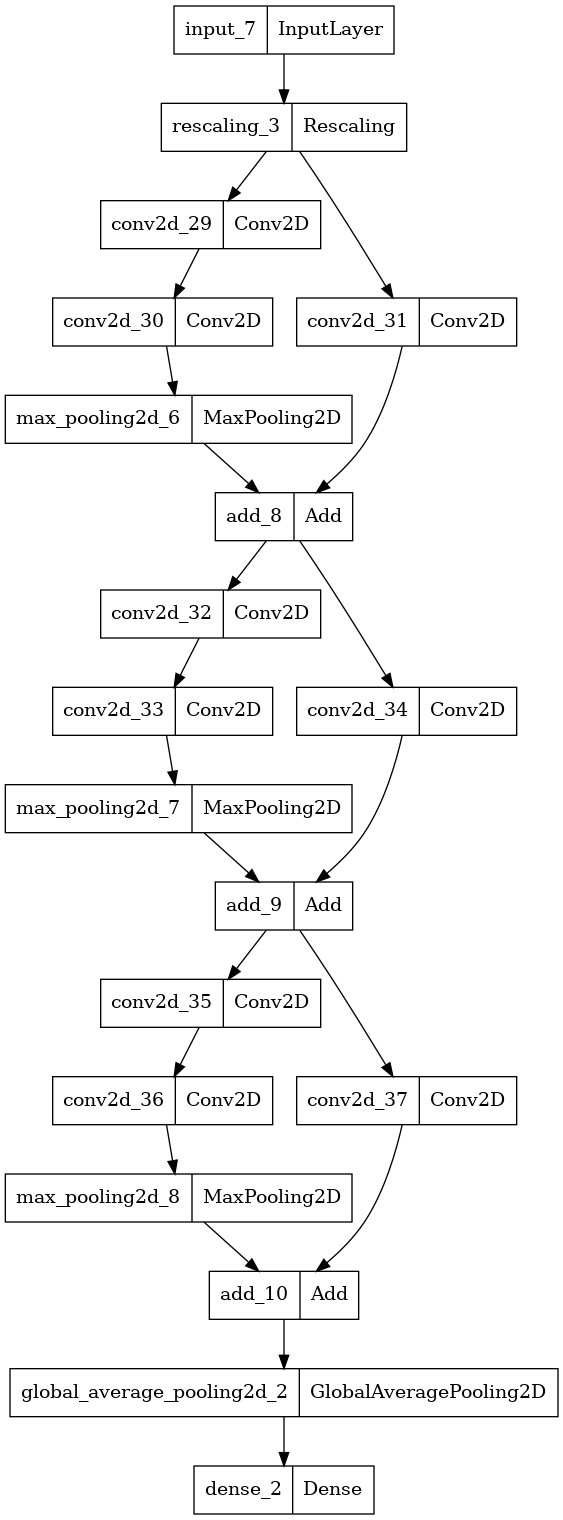

In [16]:
def residual_blocks(x, filters, pooling=False):

    residual = x

    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)

    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filter, 1)(residual)
    
    x = layers.add([x, residual])

    return x



inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)

x =  residual_blocks(x, filters=32, pooling=True)
x =  residual_blocks(x, filters=64, pooling=True)
x =  residual_blocks(x, filters=128, pooling=True)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

keras.utils.plot_model(model)